<a href="https://colab.research.google.com/github/Aleksandr62aa/ML_DL/blob/main/CNN_ResNet18_34_CIFAR10_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of RGB image by convolution neural network**

**Dataset CIFAR-10**

**Transfer Learning**

**Fine-tuning**

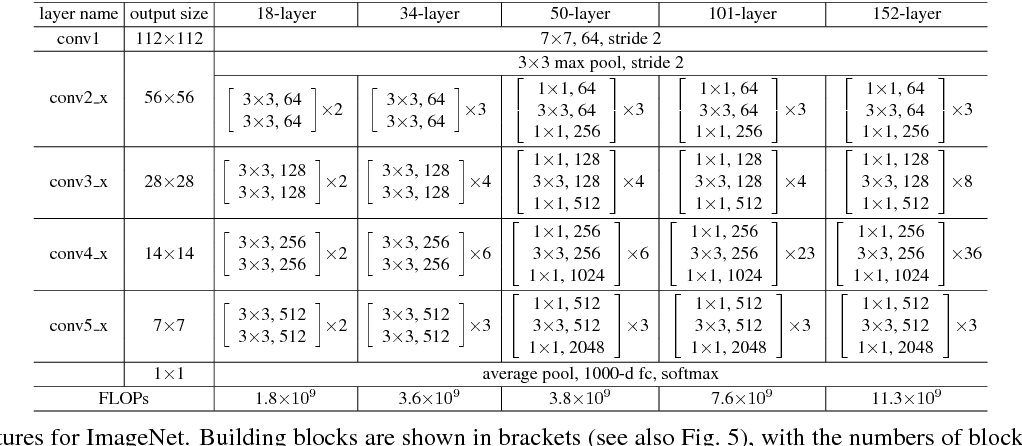


**Importing libraries**

In [36]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import models, datasets
from torchvision.transforms import ToTensor

# Fixed seed
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True

In [37]:
# Hyperparameters
num_classes = 10
batch_size = 100
num_epochs = 10
learning_rate = 1.0e-3

In [38]:
# GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Train Test dataset**

In [39]:
train_CIFAR10 = torchvision.datasets.CIFAR10('./', download=True, train=True, transform=ToTensor())
test_CIFAR10 = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=ToTensor())

train_dataloader_CIFAR10 = torch.utils.data.DataLoader(
                            train_CIFAR10, batch_size=batch_size, shuffle=True)

test_dataloader_CIFAR10 = torch.utils.data.DataLoader(
                            test_CIFAR10, batch_size=batch_size, shuffle=False, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


In [40]:
print(len(train_CIFAR10), len(train_dataloader_CIFAR10))
print(len(test_CIFAR10), len(test_dataloader_CIFAR10))

50000 500
10000 100


In [41]:
X_batch, y_batch = next(iter(train_dataloader_CIFAR10))
print(X_batch.data.shape, y_batch.data.shape)
print(X_batch[0].data.min(), X_batch[0].data.max())


torch.Size([100, 3, 32, 32]) torch.Size([100])
tensor(0.0039) tensor(0.9686)


In [42]:
train_CIFAR10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

**Image**

In [43]:
def image_plot(x):
  plt.imshow(x.permute(1, 2, 0))

tensor(8)  tensor(2)  tensor(3)  tensor(5)  tensor(2)  tensor(9)  tensor(9)  tensor(0)  tensor(0)  tensor(8)  

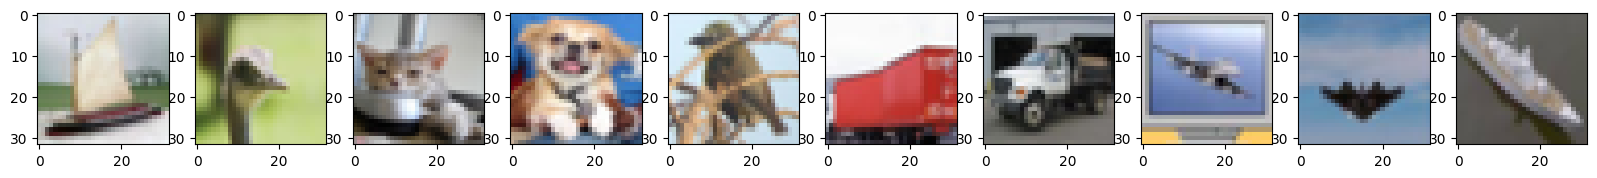

In [44]:
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_batch[i].permute(1, 2, 0))
    print(y_batch[i], end='  ')

**Model CNN**

In [45]:
model = models.resnet18(pretrained=True)
# model = models.resnet34(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# for name, child in model.named_children():
#   if name in ['layer4', 'fc']:
#     for param in child.parameters():
#       param.requires_grad = True
#   else:
#     for param in child.parameters():
#       param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, out_features=num_classes, bias=True)

model.to(device);

In [46]:
for name, param in model.named_parameters():
  if param.requires_grad:
    print("\t",name, "- True")
  else:
    print("\t",name, "- False")

	 conv1.weight - True
	 bn1.weight - True
	 bn1.bias - True
	 layer1.0.conv1.weight - True
	 layer1.0.bn1.weight - True
	 layer1.0.bn1.bias - True
	 layer1.0.conv2.weight - True
	 layer1.0.bn2.weight - True
	 layer1.0.bn2.bias - True
	 layer1.1.conv1.weight - True
	 layer1.1.bn1.weight - True
	 layer1.1.bn1.bias - True
	 layer1.1.conv2.weight - True
	 layer1.1.bn2.weight - True
	 layer1.1.bn2.bias - True
	 layer2.0.conv1.weight - True
	 layer2.0.bn1.weight - True
	 layer2.0.bn1.bias - True
	 layer2.0.conv2.weight - True
	 layer2.0.bn2.weight - True
	 layer2.0.bn2.bias - True
	 layer2.0.downsample.0.weight - True
	 layer2.0.downsample.1.weight - True
	 layer2.0.downsample.1.bias - True
	 layer2.1.conv1.weight - True
	 layer2.1.bn1.weight - True
	 layer2.1.bn1.bias - True
	 layer2.1.conv2.weight - True
	 layer2.1.bn2.weight - True
	 layer2.1.bn2.bias - True
	 layer3.0.conv1.weight - True
	 layer3.0.bn1.weight - True
	 layer3.0.bn1.bias - True
	 layer3.0.conv2.weight - True
	 layer3.0.bn2

**Loss function**

In [47]:
loss_fn = torch.nn.CrossEntropyLoss()

**Optimizer**

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)

**Training procedure**

In [49]:
test_accuracy_history = []
test_loss_history = []

for epoch in range(num_epochs):
  for batch in train_dataloader_CIFAR10:

      optimizer.zero_grad()
      model.train()

      X_batch, y_batch = batch

      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      y_preds = model(X_batch)

      loss_train = loss_fn(y_preds, y_batch)

      loss_train.backward()
      optimizer.step()

  running_loss = 0.
  running_acc = 0.

  for batch in test_dataloader_CIFAR10:
      model.eval()
      X_batch, y_batch = batch

      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      y_preds = model(X_batch)

      running_loss += loss_fn(y_preds, y_batch).item()
      running_acc += (y_preds.argmax(dim=1) == y_batch.data).float().mean().cpu()

  epoch_loss = running_loss / len(test_dataloader_CIFAR10)
  test_loss_history.append(epoch_loss)

  epoch_acc = running_acc / len(test_dataloader_CIFAR10)
  test_accuracy_history.append(epoch_acc)

  print(f"Epoch:{epoch} loss_train is {loss_train.item()}")
  print(f"accuracy_test:{epoch_acc} loss_test is {epoch_loss}")

Epoch:0 loss_train is 0.7050592303276062
accuracy_test:0.6989999413490295 loss_test is 0.8843823486566543
Epoch:1 loss_train is 0.7451302409172058
accuracy_test:0.7792999744415283 loss_test is 0.6340304780006408
Epoch:2 loss_train is 0.5299074053764343
accuracy_test:0.7491000294685364 loss_test is 0.7795013234019279
Epoch:3 loss_train is 0.39626094698905945
accuracy_test:0.8081997632980347 loss_test is 0.5816952404379845
Epoch:4 loss_train is 0.2032131403684616
accuracy_test:0.8004001379013062 loss_test is 0.6537059766054153
Epoch:5 loss_train is 0.2765699028968811
accuracy_test:0.7968999743461609 loss_test is 0.7014715331792831
Epoch:6 loss_train is 0.13326171040534973
accuracy_test:0.8036999702453613 loss_test is 0.676038124859333
Epoch:7 loss_train is 0.19864720106124878
accuracy_test:0.7649000287055969 loss_test is 0.8778575676679611
Epoch:8 loss_train is 0.059447936713695526
accuracy_test:0.8059999942779541 loss_test is 0.725919078886509
Epoch:9 loss_train is 0.18705573678016663
a

**Result test**

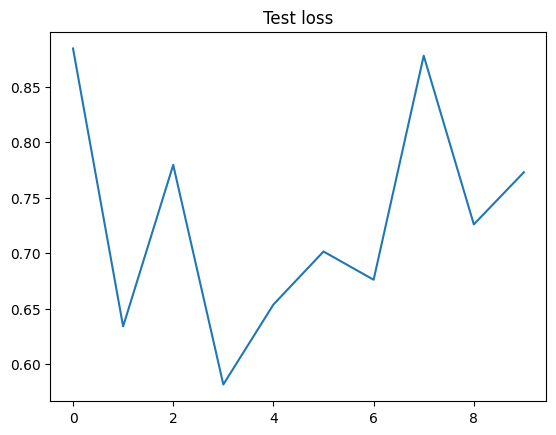

In [50]:
plt.plot(test_loss_history)
plt.title('Test loss');

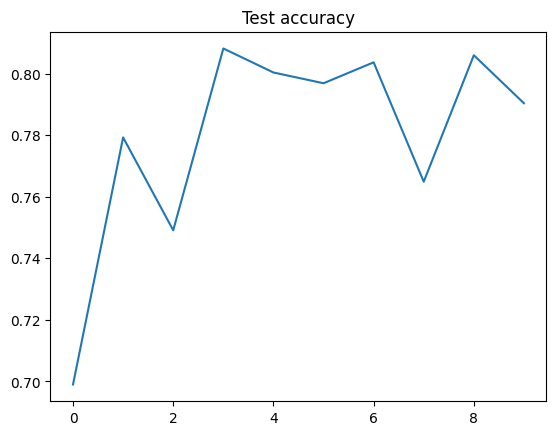

In [51]:
plt.plot(test_accuracy_history)
plt.title('Test accuracy');